In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%pip install astroML


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
def measure_accuracy(negative_class, positive_class, df):
    """
    Measure the accuracy of a classifier by calculating the precision, recall, and F1 score.
    """
    # Count of true positive (TP)
    tp = df[(df['type'] == positive_class) & (df['InsideBall'] == True)]['type'].count()

    # Count of false negative (FN)
    fn = df[(df['type'] == positive_class) & (df['InsideBall'] == False)]['type'].count()

    # Count of true negative (TN)
    tn = df[(df['type'] == negative_class) & (df['InsideBall'] == False)]['type'].count()

    # Count of false positive (FP)
    fp = df[(df['type'] == negative_class) & (df['InsideBall'] == True)]['type'].count()

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create a table
    table_data = {
        'Metric': ['True Positive (TP)', 'False Negative (FN)', 'True Negative (TN)', 'False Positive (FP)', 'Precision', 'Recall', 'F1 Score'],
        'Count': [tp, fn, tn, fp, precision, recall, f1_score]
    }

    table_df = pd.DataFrame(table_data)

    # Display the table
    return table_df

In [33]:
from astroML.datasets import fetch_rrlyrae_combined

X, y = fetch_rrlyrae_combined()

X = X[-5000:]
y = y[-5000:]

stars = (y == 0)
rrlyrae = (y == 1)

# Create a DataFrame from the array X
df = pd.DataFrame(X[:,0:2], columns=['u-g', 'g-r'])

# Add the array y as a new column to the DataFrame
df['type'] = np.where(y==0, 'stars', 'RR-Lyrae')

display(df.head())

,u-g,g-r,type
0,1.028999,0.379000,stars
1,0.945000,0.305000,stars
2,1.118000,0.396000,stars
3,0.962000,0.375000,stars
4,1.052000,0.335001,stars


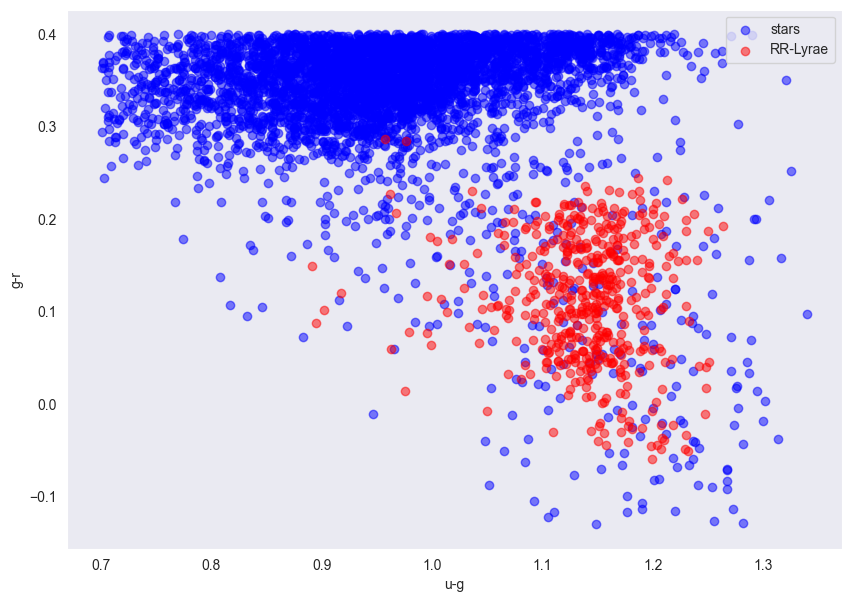

In [34]:
import matplotlib.pyplot as plt

stars_df = df[df['type'] == 'stars']
rrlyrae_df = df[df['type'] == 'RR-Lyrae']

plt.figure(figsize=(10, 7))

plt.scatter(stars_df['u-g'], stars_df['g-r'], c='b', label='stars', alpha=0.5)
plt.scatter(rrlyrae_df['u-g'], rrlyrae_df['g-r'], c='r', label='RR-Lyrae', alpha=0.5)

plt.legend(loc='upper right')

plt.xlabel('u-g')
plt.ylabel('g-r')

plt.show()

# Algorithm 3.1 The first algorithm that computes a (1 + ϵ)-approximation to MEB(A).

In [7]:
def phi(u, A):
    return sum(u[i] * np.dot(A[i].T, A[i]) for i in range(len(u))) - np.dot(sum(u[i] * A[i] for i in range(len(u))).T, sum(u[i] * A[i] for i in range(len(u))))

def create_unit_vector(idx, length):
    vec = np.zeros(length)
    vec[idx] = 1
    return vec

In [8]:
import numpy as np
import pandas as pd
import time

def frank_wolfe_alg_MEB(epsilon, A):
    """
    Frank-Wolfe algorithm for the minimum enclosing ball problem.
    """

    start_time = time.time()

    # Compute distances and indices
    distances_to_a_1 = np.linalg.norm(A - A[0], axis=1)**2 # ||a_i - a_1||^2
    alpha = np.argmax(distances_to_a_1)
    distances_to_a_alpha = np.linalg.norm(A - A[alpha], axis=1)**2 if alpha is not None else np.zeros(len(A)) # ||a_i - a_α||^2
    beta = np.argmax(distances_to_a_alpha)
    #print(f"First Value in A: {A[0]}")
    #print(f"Initial values for Alpha and Beta: {(A[alpha], A[beta])}")
    # Initialize u, chi, c
    u = np.zeros(len(A))
    u[alpha], u[beta] = 0.5, 0.5

    chi = [A[alpha], A[beta]]
    c = u @ A
    c_hist = [c]
    mu = phi(u, A)
    kappa_idxs = []

    # Main iteration loop
    distances_to_c = np.linalg.norm(A - c, axis=1)**2
    kappa = np.argmax(distances_to_c)
    delta = (distances_to_c[kappa] / mu) - 1.0
    #print(f"Initial Delta: {delta}")
    #print(f"Initial Mu: {mu}")
    k = 0
    while delta > ((1 + epsilon)**2) - 1.0 and k < 1000:
        lambd = delta / (2 * (1.0 + delta))
        k += 1
        u = (1 - lambd) * u + lambd * create_unit_vector(kappa, len(A))
        c = (1 - lambd) * c + lambd * A[kappa]
        c_hist.append(c)
        if kappa not in kappa_idxs:
            kappa_idxs.append(kappa)
            chi.append(A[kappa])
        #print(f"Kappa at iteration {k}: {A[kappa]}")
        #print(f"Delta at iteration {k}: {delta}")
        mu = phi(u, A)
        distances_to_c = np.linalg.norm(A - c, axis=1)**2
        kappa = np.argmax(distances_to_c)
        delta = (distances_to_c[kappa] / mu) - 1

    timer = time.time() - start_time
    print("Center:", c)
    print("Radius:", np.sqrt((1 + delta) * mu))
    print("Iterations:", k)
    print("CPU time:", timer)
    print("Core Set Size:", len(chi))

    return c, np.sqrt((1 + delta) * mu), k, chi, timer


Center: [1.09443863 0.11809045]
Radius: 0.21797877329853305
Iterations: 1000
CPU time: 1.3583729267120361
Core Set Size: 4


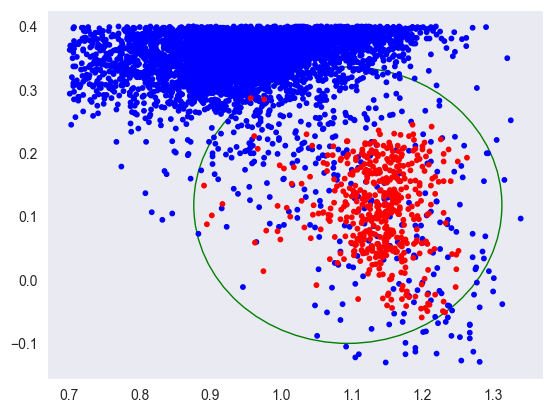

In [36]:
A = df[df['type'] == 'RR-Lyrae'][['u-g', 'g-r']].values

c, r, k, chi, timer = frank_wolfe_alg_MEB(0.0001, A)

circle = plt.Circle(tuple(c), r, color='g', fill=False)

ax = plt.gca()
ax.cla()

ax.add_patch(circle)

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['type'] == 'RR-Lyrae', 'r', 'b'), s=10)

# SSDS Quasar-Galaxy Classification

In [10]:
# open the pulsar dataset
qso_g_df = pd.read_csv('datasets/corrected_QSO_GALAXY_Dataset.csv')

# drop the rows with missing values
qso_g_df = qso_g_df.dropna()
qso_g_df.rename(columns={'class': 'type'}, inplace=True)

galaxy_df = qso_g_df[qso_g_df['type'] == 'GALAXY'].sample(n=2000, random_state=42)
qso_df = qso_g_df[qso_g_df['type'] == 'QSO'].sample(n=2000, random_state=42)

qso_g_df = pd.concat([galaxy_df, qso_df])

display(qso_g_df.head())

,type,subclass,mag_u,mag_g,mag_r,mag_i,mag_z,redshift,flux_u,flux_g,...,flux_i,flux_z,photRA,specRA,photDec,specDec,petrosianRadius_u,deVEffectiveRadius_u,petrosianRadius_z,deVEffectiveRadius_z
4498,GALAXY,STARFORMING,20.20175,18.42369,17.36100,16.85209,16.42140,0.116623,4.067745,11.13524,...,51.35847,72.29363,218.563632,218.56364,8.992736,8.992744,2.970685,7.054471,5.191600,2.716197
3646,GALAXY,STARFORMING,19.64754,18.41117,17.75667,17.36501,17.06143,0.073963,3.827840,8.99992,...,29.52955,37.28042,339.559695,339.55971,14.157285,14.157290,43.764050,26.746740,8.903262,10.204720
4242,GALAXY,STARFORMING,19.61266,17.91331,17.00628,16.59109,16.24816,0.107316,6.293722,25.02789,...,96.43300,125.75090,120.833410,120.83341,12.104724,12.104733,8.076633,6.684969,3.399417,1.761480
2464,GALAXY,STARFORMING,18.55299,17.09966,16.39841,16.01200,15.75324,0.066666,18.779910,47.22098,...,135.92570,166.69580,180.117997,180.11801,51.756060,51.756076,5.504677,4.108453,4.365156,2.409809
8715,GALAXY,STARFORMING,16.71037,15.61988,15.25153,15.01981,14.84542,0.027207,18.918650,32.80019,...,72.02156,87.63742,158.926025,158.92608,5.615982,5.615976,17.752350,29.677330,16.224320,28.178960


In [11]:
qso_g_df['u-g'] = qso_g_df['flux_u'] - qso_g_df['flux_g']
qso_g_df['g-r'] = qso_g_df['flux_g'] - qso_g_df['flux_r']
qso_g_df['r-i'] = qso_g_df['flux_r'] - qso_g_df['flux_i']
qso_g_df['i-z'] = qso_g_df['flux_i'] - qso_g_df['flux_z']
qso_g_df['u-z'] = qso_g_df['flux_u'] - qso_g_df['flux_z']
qso_g_df['u-r'] = qso_g_df['flux_u'] - qso_g_df['flux_r']
qso_g_df['r-z'] = qso_g_df['flux_r'] - qso_g_df['flux_z']


pred_columns_qso_g = ['u-z', 'u-r', 'r-z', 'redshift']
#pred_columns_qso_g = ['u-z', 'u-r', 'r-z', 'redshift', 'petrosianRadius_u', 'petrosianRadius_z']

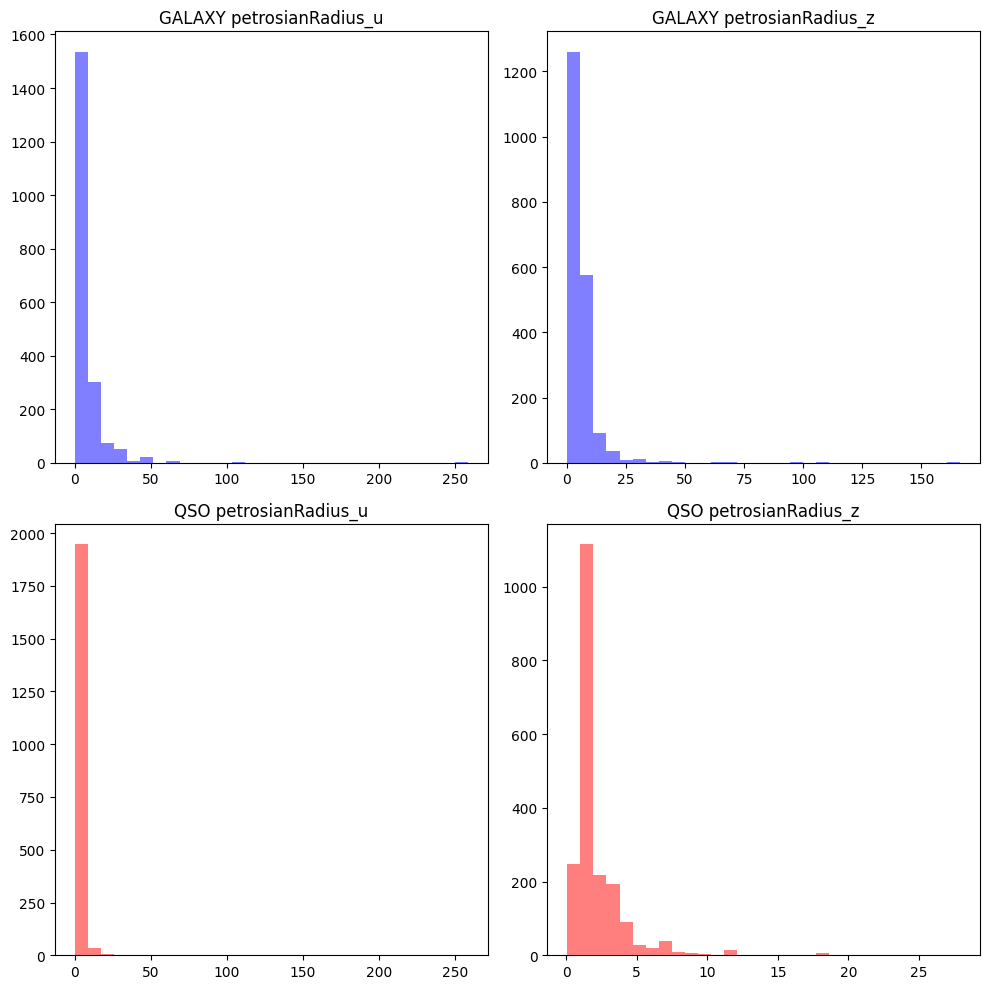

In [12]:
import matplotlib.pyplot as plt

galaxy_df = qso_g_df[qso_g_df['type'] == 'GALAXY']
qso_df = qso_g_df[qso_g_df['type'] == 'QSO']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(galaxy_df['petrosianRadius_u'], bins=30, color='b', alpha=0.5)
axs[0, 0].set_title('GALAXY petrosianRadius_u')

axs[0, 1].hist(galaxy_df['petrosianRadius_z'], bins=30, color='b', alpha=0.5)
axs[0, 1].set_title('GALAXY petrosianRadius_z')

axs[1, 0].hist(qso_df['petrosianRadius_u'], bins=30, color='r', alpha=0.5)
axs[1, 0].set_title('QSO petrosianRadius_u')

axs[1, 1].hist(qso_df['petrosianRadius_z'], bins=30, color='r', alpha=0.5)
axs[1, 1].set_title('QSO petrosianRadius_z')

plt.tight_layout()


In [13]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()

qso_g_df_norm = qso_g_df[pred_columns_qso_g]
# fit and transform the data

qso_g_df_norm = pd.DataFrame(scaler.fit_transform(qso_g_df_norm), columns=pred_columns_qso_g)

# add the 'type' column back to the normalized DataFrame
qso_g_df_norm['type'] = qso_g_df['type'].values

display(qso_g_df_norm.head())

,u-z,u-r,r-z,redshift,type
0,-0.305543,-0.156948,-0.435702,-0.815634,GALAXY
1,0.136068,0.155662,0.116330,-0.861102,GALAXY
2,-0.956166,-0.946658,-0.950819,-0.825554,GALAXY
3,-1.317584,-1.429763,-1.196716,-0.868880,GALAXY
4,-0.311803,-0.397975,-0.229181,-0.910937,GALAXY


In [14]:
from scipy import stats

train_set = qso_g_df_norm[qso_g_df_norm['type'] == 'QSO']

outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_qso_g])) > 0.5).all(axis=1)]
train_set = train_set[~train_set.isin(outliers)].dropna()

c_qso_g, r_qso_g, k_qso_g, chi_qso_g, timer_qso_g = frank_wolfe_alg_MEB(0.0001, train_set[pred_columns_qso_g].iloc[:len(train_set)//2].values)

Center: [ 0.04615014  0.17947799 -0.07531247  1.87487969]
Radius: 2.7385718794511034
Iterations: 1000
CPU time: 2.2319180965423584
Core Set Size: 5


In [15]:
# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(qso_g_df_norm[pred_columns_qso_g] - c_qso_g, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
qso_g_df_norm['InsideBall'] = distances < r_qso_g

In [16]:
positive_class = 'QSO'
negative_class = 'GALAXY'

measure_accuracy(negative_class, positive_class, qso_g_df_norm)

,Metric,Count
0,True Positive (TP),1985.000000
1,False Negative (FN),15.000000
2,True Negative (TN),1451.000000
3,False Positive (FP),549.000000
4,Precision,0.783346
5,Recall,0.992500
6,F1 Score,0.875607


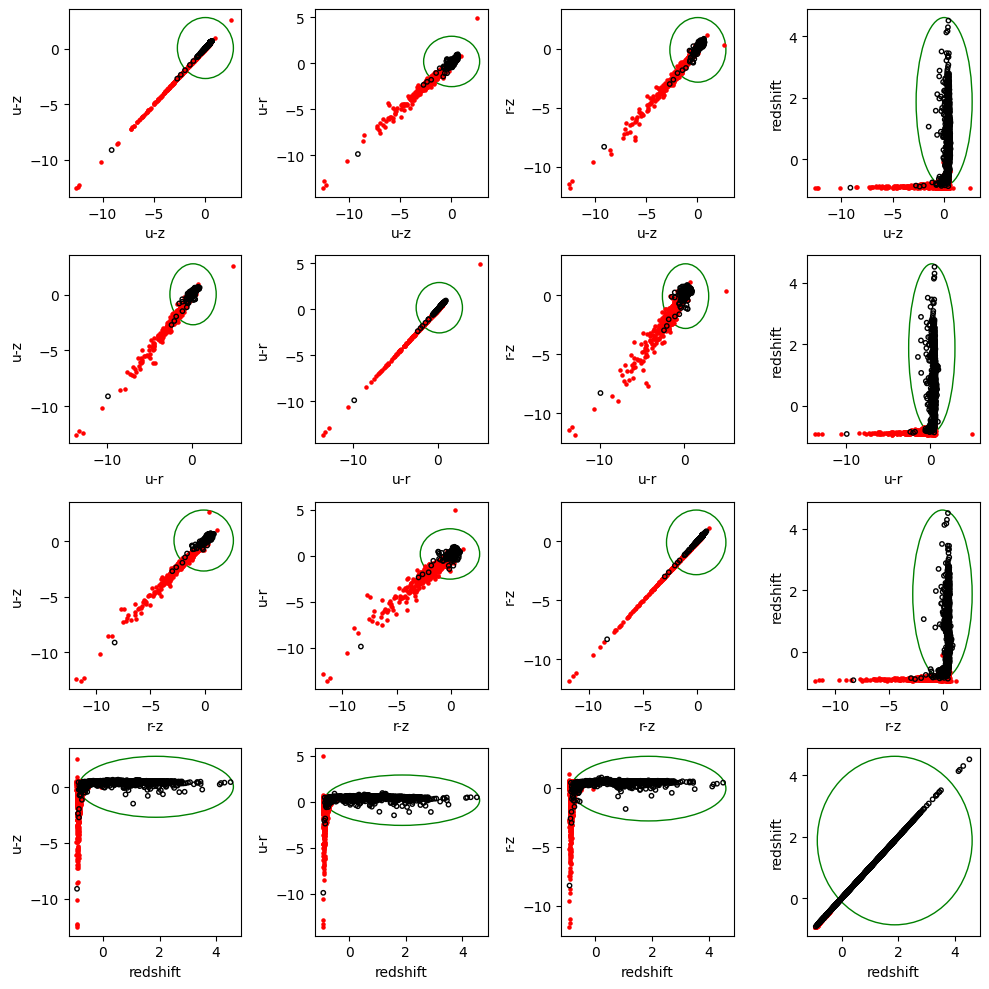

In [17]:
fig, axs = plt.subplots(len(pred_columns_qso_g), len(pred_columns_qso_g), figsize=(10, 10))

for i in range(len(pred_columns_qso_g)):
    for j in range(len(pred_columns_qso_g)):
        ax = axs[i, j]
        ax.cla()
        circle = plt.Circle(tuple(c_qso_g[[i,j]]), r_qso_g, color='g', fill=False, label='MEB')
        ax.add_patch(circle)
        
        ax.scatter(qso_g_df_norm[pred_columns_qso_g[i]][qso_g_df_norm['type'] == 'GALAXY'], qso_g_df_norm[pred_columns_qso_g[j]][qso_g_df_norm['type'] == 'GALAXY'], facecolors='r', edgecolors='r', s=5, label='Red Dwarfs')
        ax.scatter(qso_g_df_norm[pred_columns_qso_g[i]][qso_g_df_norm['type'] == 'QSO'], qso_g_df_norm[pred_columns_qso_g[j]][qso_g_df_norm['type'] == 'QSO'], facecolors='none', edgecolors='black', s=10, label='White Dwarfs')
        
        ax.set_xlabel(pred_columns_qso_g[i])
        ax.set_ylabel(pred_columns_qso_g[j])
        
        #ax.legend()

plt.tight_layout()
plt.show()

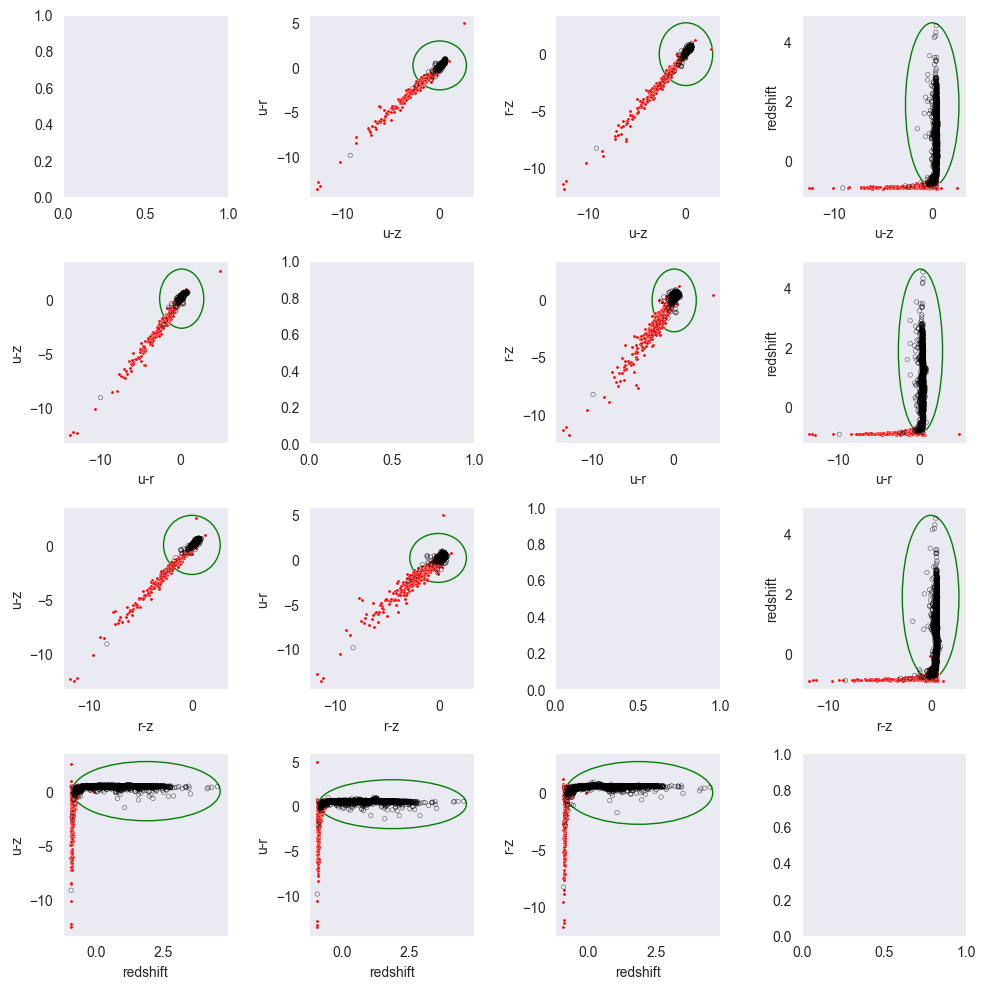

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame qso_g_df_norm with the necessary columns

# Set Seaborn style
sns.set_style("dark")

# Create a figure with subplots
fig, axs = plt.subplots(len(pred_columns_qso_g), len(pred_columns_qso_g), figsize=(10, 10))

# Loop over subplots
for i in range(len(pred_columns_qso_g)):
    for j in range(len(pred_columns_qso_g)):
        if i==j:
            continue
        ax = axs[i, j]
        ax.cla()
        
        # Plot the MEB circle
        circle = plt.Circle(tuple(c_qso_g[[i, j]]), r_qso_g, color='g', fill=False)
        ax.add_patch(circle)
        
        # Scatter plot for Red Dwarfs (GALAXY)
        sns.scatterplot(x=pred_columns_qso_g[i], y=pred_columns_qso_g[j], data=qso_g_df_norm[qso_g_df_norm['type'] == 'GALAXY'], color='r', ax=ax, s=5)
        
        # Scatter plot for White Dwarfs (QSO)
        sns.scatterplot(x=pred_columns_qso_g[i], y=pred_columns_qso_g[j], data=qso_g_df_norm[qso_g_df_norm['type'] == 'QSO'], color='none', edgecolor='black', ax=ax, s=10)
        
        ax.set_xlabel(pred_columns_qso_g[i])
        ax.set_ylabel(pred_columns_qso_g[j])
        
        # Set legend for the first subplot
        #if i == 0 and j == 0:
        #    ax.legend()

plt.tight_layout()
plt.show()


# Red Dwarfs vs. White Dwarfs

In [19]:
red_dwarfs = pd.read_csv('datasets/red_dwarfs.csv')
white_dwarfs = pd.read_csv('datasets/white_dwarfs.csv')

red_dwarfs['type'] = 'red'
white_dwarfs['type'] = 'white'

red_dwarfs = red_dwarfs[red_dwarfs['subclass'].str.startswith('K') | red_dwarfs['subclass'].str.startswith('M')]
white_dwarfs = white_dwarfs[white_dwarfs['subclass'] == 'WD']

red_dwarfs = red_dwarfs.iloc[:2000]
white_dwarfs = white_dwarfs.iloc[:2000]

dwarfs = pd.concat([red_dwarfs, white_dwarfs], ignore_index=True)

dwarfs = dwarfs.dropna()

#dwarfs = dwarfs.sample(frac=1).reset_index(drop=True)

display(dwarfs.head())

,spectroFlux_u,spectroFlux_g,spectroFlux_r,spectroFlux_i,spectroFlux_z,class,subclass,type
0,0.690362,2.639864,6.609772,9.040903,10.89239,STAR,K1,red
1,1.696024,5.127242,11.380340,15.288570,18.13893,STAR,K1,red
2,1.939370,6.556342,14.391160,19.006530,22.24492,STAR,K1,red
3,2.038488,9.414086,19.352240,25.074530,29.21216,STAR,K1,red
4,1.535014,5.447570,11.538370,15.077310,20.65042,STAR,K1,red


In [20]:
dwarfs['u-g'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_g']
dwarfs['g-r'] = dwarfs['spectroFlux_g'] - dwarfs['spectroFlux_r']
dwarfs['r-i'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_i']
dwarfs['i-z'] = dwarfs['spectroFlux_i'] - dwarfs['spectroFlux_z']
dwarfs['u-r'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_r']
dwarfs['r-z'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_z']
dwarfs['u-z'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_z']

pred_columns = ['u-g', 'g-r', 'r-i', 'i-z']

In [21]:
train_set = dwarfs[dwarfs['type'] == "white"]

#outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns])) > 2).all(axis=1)]
#train_set = train_set[~train_set.isin(outliers)].dropna()

c_dwarfs, r_dwarfs, k_dwarfs, chi_dwarfs, time_dwarfs = frank_wolfe_alg_MEB(0.01, train_set[pred_columns].iloc[:len(train_set)//2].values)

Center: [125.71492138 233.39717466 118.88998339  71.31551962]
Radius: 312.40908579419687
Iterations: 10
CPU time: 0.029771089553833008
Core Set Size: 4


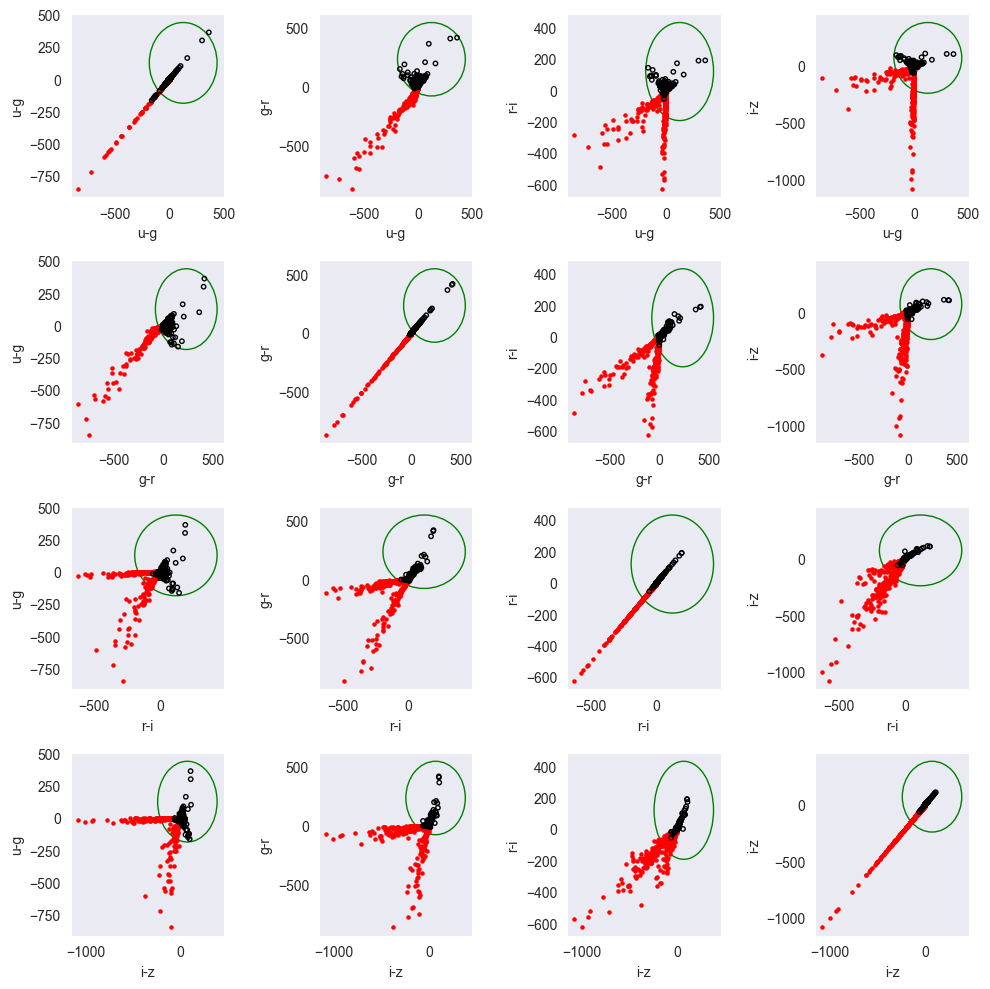

In [22]:
fig, axs = plt.subplots(len(pred_columns), len(pred_columns), figsize=(10, 10))

for i in range(len(pred_columns)):
    for j in range(len(pred_columns)):
        ax = axs[i, j]
        ax.cla()
        circle = plt.Circle(tuple(c_dwarfs[[i,j]]), r_dwarfs, color='g', fill=False, label='MEB')
        ax.add_patch(circle)
        
        ax.scatter(dwarfs[pred_columns[i]][dwarfs['type'] == 'red'], dwarfs[pred_columns[j]][dwarfs['type'] == 'red'], facecolors='r', edgecolors='r', s=5, label='Red Dwarfs')
        ax.scatter(dwarfs[pred_columns[i]][dwarfs['type'] == 'white'], dwarfs[pred_columns[j]][dwarfs['type'] == 'white'], facecolors='none', edgecolors='black', s=10, label='White Dwarfs')
        
        ax.set_xlabel(pred_columns[i])
        ax.set_ylabel(pred_columns[j])
        
        #ax.legend()

plt.tight_layout()
plt.show()

In [23]:
# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(dwarfs[pred_columns] - c_dwarfs, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
dwarfs['InsideBall'] = distances < r_dwarfs

In [24]:
measure_accuracy("red", "white", dwarfs)

,Metric,Count
0,True Positive (TP),1991.000000
1,False Negative (FN),9.000000
2,True Negative (TN),1546.000000
3,False Positive (FP),416.000000
4,Precision,0.827171
5,Recall,0.995500
6,F1 Score,0.903563
